In [ ]:
import pandas as pd
from utils import data_wrangling as dw
from utils import ts_wrangling as tw
from utils import plots 
#from models import lf_models
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import seaborn as sns
import pickle
import joblib
from benedict import benedict
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    CrostonOptimized,
    TSB,
    MSTL,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoETS,
    AutoCES,
    AutoTheta,
)

In [2]:
INIT = "2012-01-01"
END = "2023-02-28"
PERIOD = 24*365
HORIZON = 24*2

# Dados

In [3]:
load = dw.ons_data(freq='h', ano_inicio=2012, ano_fim=2023, idreg="S")
df_load = dw.pipeline(load).loc[INIT:END,:]
df_load = df_load.iloc[-PERIOD:,:]
train, test = tw.train_test_split(df_load, test=HORIZON)
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-03-01 00:00:00 to 2023-02-28 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_reg      8760 non-null   category
 1   desc_reg    8760 non-null   category
 2   load_mwmed  8760 non-null   float64 
dtypes: category(2), float64(1)
memory usage: 154.4 KB


In [4]:
df_load.describe()

,load_mwmed
count,8760.000000
mean,11641.760189
std,2295.359889
min,5755.558000
25%,9782.649250
50%,11768.670030
75%,13344.280750
max,18345.403000


# Modelos - Nixtla

In [23]:
# df_fc = lf_models.auto_arima_model(df=train, h_=HORIZON)
# df_fc.head()

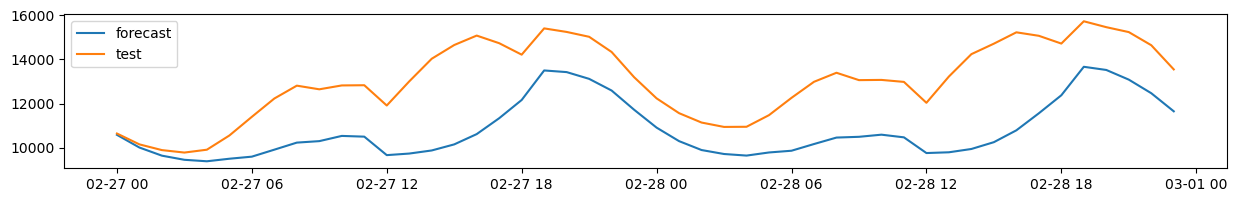

In [36]:
# plt.figure(figsize=(15,2))
# plt.plot(df_fc.ds, df_fc.AutoARIMA, label="forecast")
# plt.plot(test.index, test.load_mwmed, label="test")
# plt.legend()
# plt.show()

## Comparação de modelos

In [54]:
df_sf = dw.prepare_statsforecast_df(train, "hourly_load")

In [55]:
sf, forecasts_df = lf_models.compare_models(df=train, h_=HORIZON, level=[90,95,99])

In [16]:
# forecasts_df_arima = forecasts_df[[x for x in forecasts_df.columns if "ARIMA" in x or "ds" in x]]
# forecasts_df_arima.head()

In [8]:
forecasts_df.head()

,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-lo-95,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoARIMA-hi-95,AutoARIMA-hi-99,CrostonClassic,CrostonOptimized,...,AutoETS-hi-95,AutoETS-hi-99,CES,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,AutoTheta-lo-95,AutoTheta-hi-95,AutoTheta-lo-99,AutoTheta-hi-99
unique_id,,,,,,,,,,,,,,,,,,,,,
hourly_load,2023-02-27 00:00:00,10583.355469,9818.888672,10001.667969,10095.188477,11071.523438,11165.043945,11347.823242,10750.967773,11754.276367,...,12614.221680,13011.828125,11460.994141,11335.722656,10354.405273,12573.477539,10263.340820,12612.908203,9873.739258,12827.451172
hourly_load,2023-02-27 01:00:00,10007.152344,8580.058594,8921.267578,9095.849609,10918.455078,11093.037109,11434.246094,10750.967773,11754.276367,...,13162.786133,13726.069336,11423.147461,11335.722656,9852.372070,12884.868164,9511.812500,13044.305664,9174.249023,13708.076172
hourly_load,2023-02-27 02:00:00,9638.824219,7719.761719,8178.598145,8413.363281,10864.285156,11099.050781,11557.886719,10750.967773,11754.276367,...,13590.881836,14281.987305,11376.624023,11335.722656,9185.199219,13169.217773,8942.464844,13455.631836,8699.185547,14012.373047
hourly_load,2023-02-27 03:00:00,9451.693359,7219.575195,7753.261230,8026.324219,10877.062500,11150.125977,11683.811523,10750.967773,11754.276367,...,13956.975586,14756.420898,11337.295898,11335.722656,9159.901367,13208.197266,8853.460938,13802.066406,8025.460938,14847.213867
hourly_load,2023-02-27 04:00:00,9384.501953,6976.620117,7552.330078,7846.894531,10922.108398,11216.672852,11792.382812,10750.967773,11754.276367,...,14283.671875,15179.077148,11292.523438,11335.722656,9096.256836,13600.580078,8364.412109,14128.871094,7620.568848,14514.342773


In [10]:
crossval_df = lf_models.crossval(sf=sf, data=df_sf)
metrics_df, top = lf_models.crossval_summary_table(crossval_df)


In [11]:
metrics_df

,AutoARIMA,CrostonClassic,CrostonOptimized,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,MSTL,AutoETS,CES,AutoTheta,best_model,metric
unique_id,,,,,,,,,,,,
hourly_load,1.652954e+03,2.247784e+03,2.459183e+03,1.410173e+03,1.646164e+03,1.571671e+03,458.485962,1.973990e+03,1.806755e+03,1.855117e+03,MSTL,mean_absolute_error
hourly_load,3.841199e+06,6.134624e+06,7.393277e+06,2.976568e+06,3.555754e+06,3.668218e+06,308453.468750,4.823229e+06,3.739583e+06,4.175892e+06,MSTL,mean_squared_error
hourly_load,3.841199e+06,6.134624e+06,7.393277e+06,2.976568e+06,3.555754e+06,3.668218e+06,308453.468750,4.823229e+06,3.739583e+06,4.175892e+06,MSTL,mean_squared_error
hourly_load,1.676916e-01,2.295654e-01,2.527711e-01,1.408378e-01,1.695073e-01,1.583805e-01,0.044464,2.032261e-01,1.810998e-01,1.897660e-01,MSTL,mean_absolute_percentage_error
hourly_load,-1.179998e+00,-2.511303e+00,-3.132295e+00,-8.618599e-01,-7.641998e-01,-1.009915e+00,0.833807,-1.643322e+00,-1.030364e+00,-1.278093e+00,CrostonOptimized,r2_score
hourly_load,1.494434e-01,2.011608e-01,2.180046e-01,1.275014e-01,1.534643e-01,1.410429e-01,0.045788,1.800134e-01,1.667923e-01,1.704277e-01,MSTL,MeanAbsolutePercentageError


In [12]:
top # MELHOR MODELO: MSTL

,0
best_model,
CrostonOptimized,1
MSTL,5


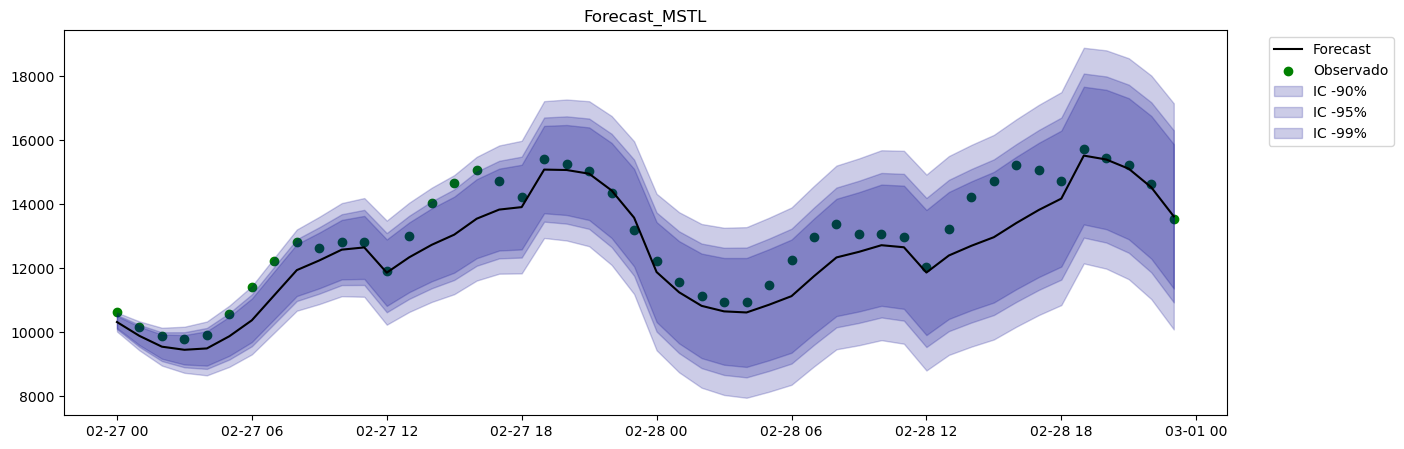

In [21]:
MSTL_fcs = tw.extract_model_cols(forecasts_df, "MSTL")
plots.plot_with_confidence(data=MSTL_fcs, x_="ds", y_="MSTL", levels=[90,95,99], test=test["load_mwmed"], title_=f"Forecast_MSTL", save=True)

# Prophet

In [7]:
import fbprophet
from fbprophet.diagnostics import cross_validation
import datetime as dt
#from models import lf_models

In [8]:
train_ts = train.reset_index()[["date","load_mwmed"]]
train_ts.columns = ['ds', 'y']
train_ts

,ds,y
0,2022-03-01 00:00:00,13519.673
1,2022-03-01 01:00:00,12853.674
2,2022-03-01 02:00:00,12314.595
3,2022-03-01 03:00:00,12097.324
4,2022-03-01 04:00:00,12025.326
...,...,...
8707,2023-02-26 19:00:00,12980.548
8708,2023-02-26 20:00:00,13008.336
8709,2023-02-26 21:00:00,12665.633
8710,2023-02-26 22:00:00,12147.929


In [ ]:
model = fbprophet.Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_ts)

In [ ]:
future_fbp = model.make_future_dataframe(periods=48, freq='h', include_history=False)
forecast = model.predict(future_fbp)
plt.figure(figsize=(15,5))
plt.plot(forecast.index, forecast.yhat)
plt.scatter(forecast.index, test.load_mwmed)
plt.show()

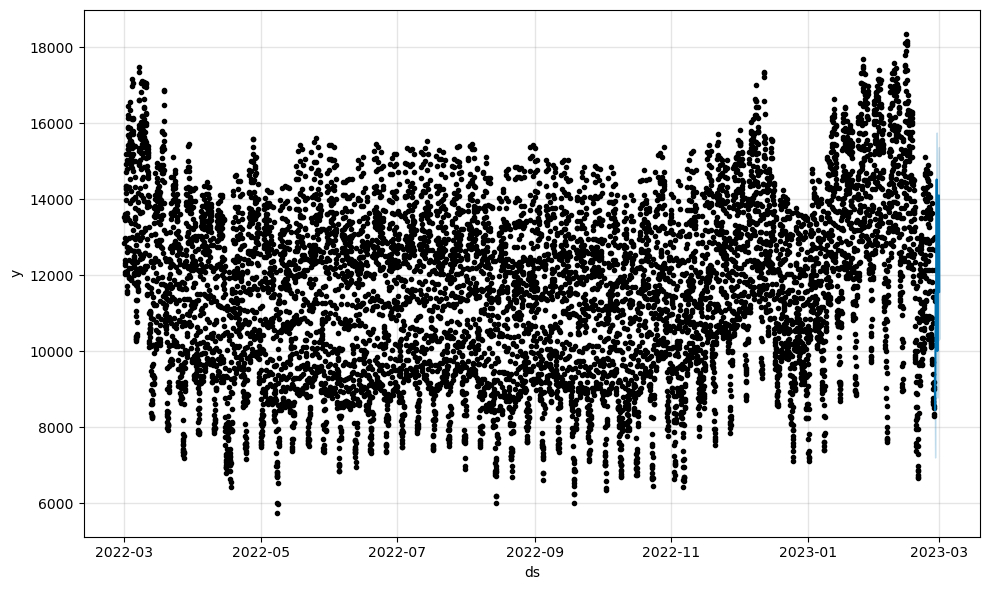

In [11]:
model.plot(forecast)
plt.show()

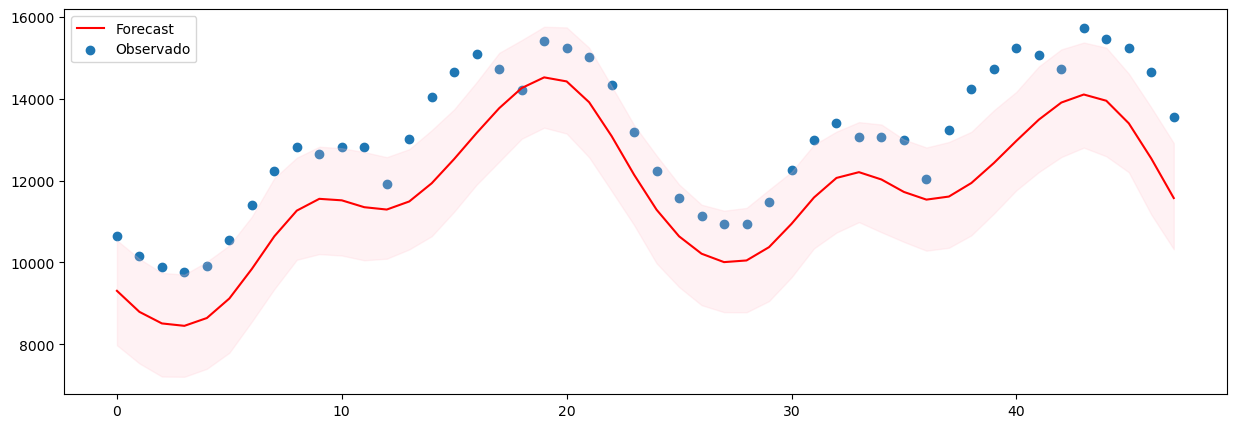

In [24]:
plt.figure(figsize=(15,5))
plt.plot(forecast.index, forecast.yhat, label="Forecast", color="red")
plt.scatter(forecast.index, test.load_mwmed, label="Observado")
plt.fill_between(forecast.index, forecast.yhat_upper, forecast.yhat_lower, alpha=.2, color="pink")
plt.legend()
plt.show()

In [9]:
train.head(2)

,id_reg,desc_reg,load_mwmed
date,,,
2022-03-01 00:00:00,S,SUL,13519.673
2022-03-01 01:00:00,S,SUL,12853.674


In [ ]:
fc

## Cross validation
https://stackoverflow.com/questions/63780573/trying-to-understand-fb-prophet-cross-validation


In [ ]:
initial = '332 days'
horizon = '48 hours'
period = '24 hours' #cutoff (steps); := initial + period
df_cv = cross_validation(model, horizon=horizon, period=period, initial=initial)

In [96]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-28 00:00:00,13316.006968,12151.724678,14547.166949,15316.058,2023-01-27 23:00:00
1,2023-01-28 01:00:00,12594.480723,11465.841677,13906.182778,14431.520,2023-01-27 23:00:00
2,2023-01-28 02:00:00,12093.593182,10796.437444,13391.207218,13751.679,2023-01-27 23:00:00
3,2023-01-28 03:00:00,11815.349485,10694.033845,13035.402673,13308.677,2023-01-27 23:00:00
4,2023-01-28 04:00:00,11794.286909,10581.962266,12997.064665,12958.667,2023-01-27 23:00:00
...,...,...,...,...,...,...
1387,2023-02-26 19:00:00,11635.037790,10269.780916,12861.877390,12980.548,2023-02-24 23:00:00
1388,2023-02-26 20:00:00,11618.020664,10242.701149,12938.742752,13008.336,2023-02-24 23:00:00
1389,2023-02-26 21:00:00,11205.401601,9988.527647,12417.802886,12665.633,2023-02-24 23:00:00
1390,2023-02-26 22:00:00,10486.197451,9236.360056,11717.419175,12147.929,2023-02-24 23:00:00


# AutoARIMA

In [62]:
sf, df_forecast = lf_models.auto_arima_model(df=train,
                                             h_=48,
                                             level=[99,95,90])

## Saving models

In [12]:
joblib.dump(sf, '../models/sf_autoarima_joblib')

['models/sf_autoarima_joblib']

In [13]:
sf_autoarima = joblib.load('models/sf_autoarima_joblib')

In [5]:
sf_autoarima = joblib.load('../models/autoarima_joblib')

In [9]:
from pprint import pprint
sf_autoarima.models[0].model_

{'coef': {'ar1': 1.576349293178381,
  'ar2': -0.8065257665446013,
  'ar3': 0.11690463743052477,
  'sar1': -0.2764573522131184,
  'sar2': -0.3354229188825696},
 'sigma2': 88033.10700891988,
 'var_coef': array([[ 1.04166304e-09, -3.48351153e-10,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-7.56912812e-09,  6.13734620e-09,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 2.24374419e-08, -3.26994372e-08,  1.28856386e-08,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.32483068e-08,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          4.59655935e-09,  1.04419077e-08]]),
 'mask': array([ True,  True,  True,  True,  True]),
 'loglik': -61787.49020320049,
 'aic': 123586.98040640098,
 'arma': (3, 0, 2, 0, 24, 0, 1),
 'residuals': array([  13.51957313,   12.85339231,   12.31416748, ...,  -36.54159886,
          70.04694547, -233.85017553]),
 'code

## Tentando extrair ordem dos parâmetros do AutoARIMA

In [67]:
sf.models[0].model_ # erro; precisa rodar .fit antes no modelo

AttributeError: 'AutoARIMA' object has no attribute 'model_'

In [68]:
sf.models[0].fit(df_sf["y"].values)

AutoARIMA

In [ ]:
sf.models[0].model_

In [ ]:
sf_autoarima.forecast(h=48)

In [40]:
from utils.data_wrangling import prepare_statsforecast_df
df_sf = prepare_statsforecast_df(train, 'hora')
sf_autoarima.models[0].fit(df_sf["y"].values)

AutoARIMA

In [52]:
from pprint import pprint
model_coefs = sf_autoarima.models[0].model_
pprint(model_coefs)
# {'arma': (3, 0, 2, 0, 24, 0, 1),
#  'bic': 123629.39790400655,
#  'coef': {'ar1': 1.576349293178381,
#           'ar2': -0.8065257665446013,
#           'ar3': 0.11690463743052477,
#           'sar1': -0.2764573522131184,
#           'sar2': -0.3354229188825696}

{'aic': 123586.98040640098,
 'aicc': 123586.99008382033,
 'arma': (3, 0, 2, 0, 24, 0, 1),
 'bic': 123629.39790400655,
 'code': 2,
 'coef': {'ar1': 1.576349293178381,
          'ar2': -0.8065257665446013,
          'ar3': 0.11690463743052477,
          'sar1': -0.2764573522131184,
          'sar2': -0.3354229188825696},
 'ic': None,
 'lambda': None,
 'loglik': -61787.49020320049,
 'mask': array([ True,  True,  True,  True,  True]),
 'model': {'P': array([[ 0.00000000e+00,  1.50171527e-16, -6.86035459e-17, ...,
        -2.77116253e-15, -2.14743864e-15, -3.98027317e-18],
       [ 1.50171527e-16, -7.98075322e-16,  1.73860873e-16, ...,
         6.93518279e-16,  6.78412077e-16, -1.50171527e-16],
       [-6.86035459e-17,  1.73860873e-16,  1.91453679e-16, ...,
        -1.27125497e-16,  1.27941396e-16,  6.86035459e-17],
       ...,
       [-2.77116253e-15,  6.93518279e-16, -1.27125497e-16, ...,
        -2.86209475e-17, -1.65687982e-29, -1.23942252e-29],
       [-2.14743864e-15,  6.78412077e-16,

In [45]:
model_coefs["arma"]

(3, 0, 2, 0, 24, 0, 1)

# SKTIME

In [6]:
from sktime.forecasting.compose import make_reduction
import lightgbm as lgb

In [7]:
train2 = train["load_mwmed"]
train_ts = train2.asfreq('H')

In [8]:
regressor = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
forecaster = make_reduction(regressor, window_length=60, strategy="recursive")
forecaster.fit(train_ts)   # fit 
predictions = forecaster.predict(fh = [x for x in range(1,48 + 1)]) 

In [9]:
predictions

2023-02-27 00:00:00    10504.347300
2023-02-27 01:00:00     9935.182599
2023-02-27 02:00:00     9696.868166
2023-02-27 03:00:00     9502.400662
2023-02-27 04:00:00     9491.506982
2023-02-27 05:00:00     9352.268850
2023-02-27 06:00:00     9705.181266
2023-02-27 07:00:00    10362.521192
2023-02-27 08:00:00    11141.101860
2023-02-27 09:00:00    11475.071933
2023-02-27 10:00:00    11390.920866
2023-02-27 11:00:00    11154.458721
2023-02-27 12:00:00    10580.148299
2023-02-27 13:00:00    10663.410315
2023-02-27 14:00:00    11123.048339
2023-02-27 15:00:00    11682.040427
2023-02-27 16:00:00    12354.443813
2023-02-27 17:00:00    13025.481516
2023-02-27 18:00:00    13239.061162
2023-02-27 19:00:00    14251.437752
2023-02-27 20:00:00    14374.823925
2023-02-27 21:00:00    14148.949367
2023-02-27 22:00:00    13504.255013
2023-02-27 23:00:00    12425.013506
2023-02-28 00:00:00    11488.755645
2023-02-28 01:00:00    10759.039577
2023-02-28 02:00:00    10300.162630
2023-02-28 03:00:00     9928

# HOLT WINTERS

In [ ]:
import os

# Define the root directory of your project
ROOT_DIR = os.path.dirname(os.getcwd())
ROOT_DIR

In [ ]:
ROOT_DIR

In [35]:
from typing import Optional
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from datetime import datetime

def holt_winters_model(data: pd.Series,
                       y_col: str,
                       horizon: int,
                       seasonality: int,
                       trend_: str,
                       seasonal_: str,
                       test: Optional[pd.Series],
                       write: bool=True,
                       save_model: bool=False) -> pd.DataFrame:
    """_summary_

    Args:
        data (pd.Series): _description_
        horizon (int): _description_
        test (Optional[pd.Series]): _description_
        seasonality (int): _description_
        trend_ (str): _description_
        seasonal_ (str): _description_
        write (bool, optional): _description_. Defaults to True.
        save_model (bool, optional): _description_. Defaults to False.

    Returns:
        pd.DataFrame: _description_
    """
    x = data[y_col]
    fitted_model = ExponentialSmoothing(x, seasonal_periods=seasonality, trend=trend_, seasonal=seasonal_).fit()
    forecast = fitted_model.forecast(horizon)
    forecast_df = pd.DataFrame({"date": forecast.index.values, "load_mwmed": forecast.values})
    plt.figure(figsize=(15,5))
    plt.plot(forecast_df["date"], forecast_df["load_mwmed"], label="Forecast")
    if test is not None:
        plt.scatter(test.index, test, label="Observado")
    if write:
        now = datetime.now().strftime("%Y%m%d_%H%M%S")
        forecast_df.to_parquet(f"../data/forecasts/holtwinters_fc_{now}.parquet")
    if save_model:
        joblib.dump(fitted_model, '../models/holtwinters_joblib')
    return forecast

fc = holt_winters_model(data=train, y_col="load_mwmed", horizon=HORIZON, seasonality=24, trend_="add", seasonal_="mul", test=test["load_mwmed"], save_model=True)


# Misc

In [23]:
def get_seasonal_components(date_col: pd.Series, frequency="H") -> pd.DataFrame:
    """_summary_

    Args:
        date_col (pd.Series): _description_

    Returns:
        pd.DataFrame: _description_
    """
    if isinstance(date_col, pd.core.indexes.datetimes.DatetimeIndex):
        date_col = date_col.to_series()
    y = pd.DataFrame()
    y["data"] = date_col
    y["ano"] = date_col.dt.year
    y["trimestre"] = date_col.dt.quarter
    y["mes"] = date_col.dt.month
    if (frequency=="d") or (frequency=="H"):
        y["semana_ano"] = date_col.dt.isocalendar().week
        y["dia"] = date_col.dt.day
        y["dia_ano"] = date_col.dt.dayofyear
        y["dia_semana"] = date_col.dt.weekday + 1    # 1: segunda-feira; 7: domingo
    if frequency=="H":
        y["hora"] = date_col.dt.hour
    #y["apagao"] = date_col.dt.year.apply(lambda x: 1 if x in [2001, 2002] else 0) # apagão de 2001 e 2002
    return y

In [25]:
get_seasonal_components(df_load.index, frequency="d")

,data,ano,trimestre,mes,semana_ano,dia,dia_ano,dia_semana
date,,,,,,,,
2022-03-01 00:00:00,2022-03-01 00:00:00,2022,1,3,9,1,60,2
2022-03-01 01:00:00,2022-03-01 01:00:00,2022,1,3,9,1,60,2
2022-03-01 02:00:00,2022-03-01 02:00:00,2022,1,3,9,1,60,2
2022-03-01 03:00:00,2022-03-01 03:00:00,2022,1,3,9,1,60,2
2022-03-01 04:00:00,2022-03-01 04:00:00,2022,1,3,9,1,60,2
...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,2023-02-28 19:00:00,2023,1,2,9,28,59,2
2023-02-28 20:00:00,2023-02-28 20:00:00,2023,1,2,9,28,59,2
2023-02-28 21:00:00,2023-02-28 21:00:00,2023,1,2,9,28,59,2


In [6]:
class SerieTemporal:
    """Classe para armazenar informações da série temporal.
    frequency: str
        Frequência da série temporal. Pode ser 'H' (horária) ou 'd' (diária).
    """
    def __init__(self,
                 data: pd.DataFrame,
                 y_col: str,
                 date_col_name: str,
                 test_size: int,
                 frequency: str,
                 seasonality: int=24):
        self.data = data
        self.y_col = y_col
        self.full_series = data[y_col]
        self.date_col_name = date_col_name
        self.train = data.iloc[:-test_size][y_col]
        self.horizon = test_size
        self.test = data.iloc[-test_size:][y_col]
        self.frequency = frequency  
        self.seasonality = seasonality

class Projecoes:
    def __init__(self, 
                 ts: SerieTemporal):
        self.ts = ts
        self.models = {}
    
    def prophet_fit_forecast(self, write: bool=True):
        ts = self.ts.data.reset_index()[[self.ts.date_col_name, self.ts.y_col]].copy()
        ts.columns = ["ds", "y"]
        return ts 

In [31]:
ts = SerieTemporal(data=df_load, y_col = "load_mwmed", date_col_name = "date", test_size=HORIZON, frequency='h')

In [55]:
fm = Projecoes(ts=ts)

In [56]:
fm.prophet_fit_forecast()

,ds,y
0,2022-03-01 00:00:00,13519.673
1,2022-03-01 01:00:00,12853.674
2,2022-03-01 02:00:00,12314.595
3,2022-03-01 03:00:00,12097.324
4,2022-03-01 04:00:00,12025.326
...,...,...
8755,2023-02-28 19:00:00,15729.786
8756,2023-02-28 20:00:00,15462.558
8757,2023-02-28 21:00:00,15239.737
8758,2023-02-28 22:00:00,14644.277


In [5]:
from models_ import SerieTemporal, Projecoes, prophet_model

In [10]:
ts = SerieTemporal(data=df_load, y_col = "load_mwmed", date_col_name = "date", test_size=HORIZON, frequency='h')
fm = Projecoes(ts=ts)

In [ ]:
fc_p = fm.prophet_fit_forecast()

In [67]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import     MeanAbsolutePercentageError
from math import sqrt

def get_metrics(forecast: pd.Series,
                test: pd.Series):
    errors = [(test.iloc[i] - forecast.iloc[i]) for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    smape__obg = MeanAbsolutePercentageError(symmetric=True)
    smape = smape__obg(test, forecast)
    r2 = r2_score(test, forecast)
    measures = { "erro": sum(errors),
                "mae": mae,
                "mse": mse,
                "rmse": rmse,
                "mape": mape,
                "smape": smape,
                "r2": r2
            }
    return measures

In [68]:
fc = fm.forecasts['Prophet']['yhat'].values
tst = fm.ts.test.values

In [69]:
get_metrics(fc, tst)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

# Building cross validation

In [89]:
from paths import PATHS
import os
import json
import copy
PROCESSED_DATA_DIR = PATHS['processed_data']

In [29]:
from models_ import SerieTemporal, Projecoes, prophet_model
from metrics import get_metrics

In [6]:
ts = SerieTemporal(data=df_load, y_col = "load_mwmed", date_col_name = "date", test_size=HORIZON, frequency='h')
#fm = Projecoes(ts=ts)

In [51]:
dataset = ts.full_series
dataset = dataset.reset_index().set_index("date")

In [103]:
class cross_validation:
    def __init__(self, data):
        #self.ts = ts
        self.data = data
        self.cutoff_dates = []
        self.training_dates = {}
        self.partitions = []
        self.test_partitions = []
        #self.models = models or []

    def slider(self,
               use_x_days: str,
               horizon: int,
               y_col: str):
        # if horizon is None:
        #     horizon = pd.Timedelta(f"{self.ts.horizon} hours")
        use_x_days = pd.Timedelta(use_x_days)
        horizon = pd.Timedelta(horizon)
        min_date = self.data.index.min()
        max_date = self.data.index.max()
        initial_training_date = min_date + use_x_days
        n_partitions = int(len(pd.date_range(initial_training_date, max_date, freq='h'))/(horizon.total_seconds()/3600))
        t = {}
        for i in range(1, n_partitions+1):
            start = self.data.index.max() - ((horizon*(i+1)) - pd.Timedelta("1 hour"))
            self.cutoff_dates.append(start)
            end = start + (horizon - pd.Timedelta("1 hour"))
            x = self.data.loc[:end]#.index
            #self.partitions.append(self.data.loc[x])
            t[i] = {}
            t[i]["treino"] = series_to_tuples(index=x.index, y=x.loc[:,y_col])
            test = self.data.loc[end+pd.Timedelta("1 hour"):end+pd.Timedelta("48 hours")]
            t[i]["teste"] = series_to_tuples(index=test.index, y=test.loc[:,y_col])
        self.partitions = t
        
    def store_partitions(self):
        partitions_dict = copy.deepcopy(self.partitions)
        if partitions_dict:
            for partition in range(1, len(partitions_dict)+1):
                partitions_dict[partition]["treino"] = [(str(x[0]),x[1]) for x in partitions_dict[partition]["treino"]]
                partitions_dict[partition]["teste"] = [(str(x[0]),x[1]) for x in partitions_dict[partition]["teste"]]
            file_path = os.path.join(PROCESSED_DATA_DIR, "cross_validation_partitions.json")
            with open(file_path, 'w') as f:
                json.dump(partitions_dict, f)
        else:
            raise Exception("Atributo 'partitions' vazio: rode o cross-validation antes de salvar.")
            
def series_to_tuples(index: pd.DatetimeIndex, 
                     y: pd.Series):
    if not isinstance(y, pd.Series):
        raise Exception("Os valores não têm o tipo de Pandas Series. Tente selecionar a coluna de interesse.")
    l_tuples = list(zip(index, y.values))
    return l_tuples

In [100]:
# model = fm.prophet_fit_forecast
# method = getattr(fm, model.__name__)
# result = method()

In [105]:
# ts = SerieTemporal(data=df_load, y_col = "load_mwmed", date_col_name = "date", test_size=HORIZON, frequency='h')
# fm = Projecoes(ts=ts)
cv = cross_validation(data = dataset)
cv.slider(use_x_days="180 days", horizon="48 hours", y_col="load_mwmed")
#cv.store_partitions()

In [ ]:
for partition in cv.partitions:
    d_train = cv.partitions[partition]["treino"]
    d_test = cv.partitions[partition]["teste"]
    df_train = pd.DataFrame(d_train, columns=["ds", "y"])
    df_test = pd.DataFrame(d_test, columns=["ds", "y"])
    print(partition)
    model = prophet_model(df_train)
    future_fbp = model.make_future_dataframe(periods=HORIZON, freq='h', include_history=False)
    forecast = model.predict(future_fbp)[["ds","yhat"]]
    df_comp = pd.merge(forecast, df_test, on="ds", how="right")
    metricas = get_metrics(df_comp["yhat"], df_comp["y"])
    print(metricas["mape"])
    